In [ ]:
import cv2
import numpy as np
from skimage.filters import frangi, gabor
from skimage import measure, morphology

def master_control(image):
    b, g, r = cv2.split(image)
    
    sk_frangi_img = frangi(g, sigmas=np.linspace(0, 1, num=100), beta=1.5, gamma=0.01)
    sk_frangi_img = morphology.closing(sk_frangi_img, morphology.disk(1))
    
    sk_gabor_img_1, _ = gabor(g, frequency=0.35, theta=0)
    sk_gabor_img_2, _ = gabor(g, frequency=0.35, theta=np.deg2rad(45))
    sk_gabor_img_3, _ = gabor(g, frequency=0.35, theta=np.deg2rad(90))
    sk_gabor_img_4, _ = gabor(g, frequency=0.35, theta=np.deg2rad(360)) 
    sk_gabor_img_1 = morphology.opening(sk_gabor_img_1, morphology.disk(2))
    sk_gabor_img_2 = morphology.opening(sk_gabor_img_2, morphology.disk(1))
    sk_gabor_img_3 = morphology.opening(sk_gabor_img_3, morphology.disk(2))
    sk_gabor_img_4 = morphology.opening(sk_gabor_img_4, morphology.disk(2))
    

    all_img = cv2.add(0.1 * sk_gabor_img_2.astype(np.float32), 0.9 * sk_frangi_img.astype(np.float32))
    all_img = morphology.closing(all_img, morphology.disk(1))
    
    # Thresholding을 통해 이진화 (임계값 0.3 사용)
    _, all_img = cv2.threshold(all_img, 0.3, 1, cv2.THRESH_BINARY)
    
    # 연결 영역(연결분할) 라벨링 및 노이즈 제거
    bool_img = all_img.astype(bool)
    label_image = measure.label(bool_img)
    count = 0
    for region in measure.regionprops(label_image):
        if region.area < 10:
            for coord in region.coords:
                all_img[coord[0], coord[1]] = 0
            continue
        if region.eccentricity > 0.98:
            count += 1
        else:
            for coord in region.coords:
                all_img[coord[0], coord[1]] = 0
    
    # 남은 영역에서 중앙축(스켈레톤) 추출
    skel, distance = morphology.medial_axis(all_img.astype(int), return_distance=True)
    skels = morphology.closing(skel, morphology.disk(1))
    return skels, count

def face_wrinkle(path):

    image = cv2.imread(path)
    if image is None:
        print("이미지를 찾을 수 없습니다.")
        return
    
    skels, count = master_control(image)
    print("검출된 주름 영역 수:", count)
    
    overlay = image.copy()
    overlay[skels > 0] = [0, 0, 255]
    
    cv2.imshow("Original Image", image)
    cv2.imshow("Wrinkle Skeleton Mask", (skels * 255).astype(np.uint8))
    cv2.imshow("Overlay (Red: Wrinkle)", overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == '__main__':
    image_path = "testset/16462_Tyson_52_f.jpg"
    face_wrinkle(image_path)


/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 51025 (\N{HANGUL SYLLABLE EUNG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_172232/1597812189.py:205: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17

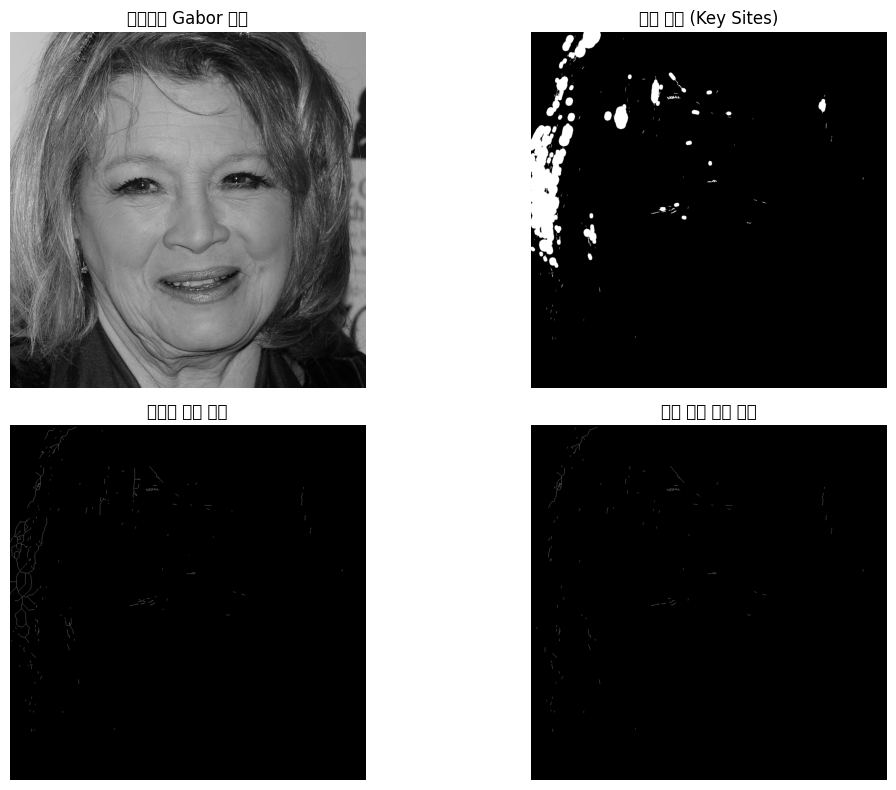

In [5]:
import cv2
import numpy as np
from skimage import morphology, measure
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

def gabor_filter_bank(image, ksize, sigma_list, lambd_list, gamma, psi, num_orientations=8):
   
    responses = []
    for sigma in sigma_list:
        for lambd in lambd_list:
            for i in range(num_orientations):
                theta = -np.pi/2 + i * (np.pi / num_orientations)
                kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
                filtered = cv2.filter2D(image, cv2.CV_32F, kernel)
                responses.append(np.abs(filtered))

    max_response = np.max(np.stack(responses, axis=-1), axis=-1)
    return max_response

def normalize_response(response, p=1.25):

    response = response - np.min(response)
    response = response ** p
    normalized = response / np.max(response)
    return normalized

def remove_blob_components(binary, min_area=10, ecc_threshold=0.98):

    label_img = measure.label(binary)
    binary_clean = np.zeros_like(binary, dtype=bool)
    for region in measure.regionprops(label_img):
        if region.area >= min_area and region.eccentricity >= ecc_threshold:
            binary_clean[label_img == region.label] = True
    return binary_clean

def detect_key_wrinkle_sites(normalized_response, thresholds, rd):

    key_sites = np.zeros_like(normalized_response, dtype=bool)
    for t in thresholds:
        binary = normalized_response > t
        binary_clean = remove_blob_components(binary)
  
        dilated = morphology.binary_dilation(key_sites, footprint=morphology.disk(rd))
        key_sites = np.logical_or(dilated, binary_clean)
    return key_sites

def find_endpoints(skel):

    endpoints = []
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    conv = convolve(skel.astype(np.int32), kernel, mode='constant', cval=0)
    ys, xs = np.where(skel)
    for y, x in zip(ys, xs):
        if conv[y, x] == 11:
            endpoints.append((y, x))
    return endpoints

def extend_wrinkle_curves(key_sites, normalized_response, tL, num_iterations=30, rE=4):

    skeleton = morphology.skeletonize(key_sites)
    endpoints = find_endpoints(skeleton)
    extended = skeleton.copy()
    
    for i in range(num_iterations):
        new_points = np.zeros_like(extended, dtype=bool)
        for y, x in endpoints:
            y_min = max(y - rE, 0)
            y_max = min(y + rE + 1, extended.shape[0])
            x_min = max(x - rE, 0)
            x_max = min(x + rE + 1, extended.shape[1])
            window = normalized_response[y_min:y_max, x_min:x_max]
            local_max = np.max(window)
            if local_max > tL:
                coords = np.argwhere(window == local_max)[0]
                new_y = y_min + coords[0]
                new_x = x_min + coords[1]
                new_points[new_y, new_x] = True
        if not new_points.any():
            break
        extended = np.logical_or(extended, new_points)
        endpoints = find_endpoints(extended)
    return extended

def remove_false_positives(extended, min_area=10, ecc_threshold=0.98):

    label_img = measure.label(extended)
    cleaned = np.zeros_like(extended, dtype=bool)
    for region in measure.regionprops(label_img):
        if region.area >= min_area and region.eccentricity >= ecc_threshold:
            cleaned[label_img == region.label] = True
    return cleaned

def detect_wrinkles(image, high_resolution=True):

    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    if high_resolution:
        sigma_list = [0.1, 0.3]
        lambd_list = [5, 10]
        gamma = 10
        rd = 10  
        rN = 6   
        rE = rN - 2  
    else:
        sigma_list = [0.1, 0.3]
        lambd_list = [5, 10]  
        gamma = 10
        rd = 7
        rN = 4
        rE = rN - 2  

    ksize = (31, 31)  
    psi = 0
    num_orientations = 8


    max_response = gabor_filter_bank(image, ksize, sigma_list, lambd_list, gamma, psi, num_orientations)
    normalized = normalize_response(max_response, p=1.25)


    tU = 1.0
    tI = 0.7   
    tL = tI - 0.1
    dt = 0.05
    thresholds = np.arange(tU, tI - dt, -dt)
    key_sites = detect_key_wrinkle_sites(normalized, thresholds, rd)

  
    extended = extend_wrinkle_curves(key_sites, normalized, tL, num_iterations=30, rE=rE)

  
    final_wrinkles = remove_false_positives(extended, min_area=10, ecc_threshold=0.98)

    return normalized, key_sites, extended, final_wrinkles

if __name__ == "__main__":
  
    image_path = "testset/12459_AngieDickinson_82_f.jpg"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("이미지를 찾을 수 없습니다.")
    else:
        normalized, key_sites, extended, final_wrinkles = detect_wrinkles(image, high_resolution=True)
        
        # 결과 시각화
        plt.figure(figsize=(12, 8))
        plt.subplot(2,2,1)
        plt.title("정규화된 Gabor 응답")
        plt.imshow(normalized, cmap='gray')
        plt.axis('off')
        
        plt.subplot(2,2,2)
        plt.title("주름 후보 (Key Sites)")
        plt.imshow(key_sites, cmap='gray')
        plt.axis('off')
        
        plt.subplot(2,2,3)
        plt.title("확장된 주름 곡선")
        plt.imshow(extended, cmap='gray')
        plt.axis('off')
        
        plt.subplot(2,2,4)
        plt.title("최종 주름 검출 결과")
        plt.imshow(final_wrinkles, cmap='gray')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
